## Setup

In [1263]:
import pandas as pd
from nltk import word_tokenize
from sklearn.naive_bayes import MultinomialNB

In [1264]:
df = pd.read_json('../input/news-category-dataset/News_Category_Dataset_v3.json', lines=True)

In [1265]:
df['category'] = df['category'].astype('category')

In [1266]:
from sklearn.model_selection import train_test_split

x = df['headline'] + ' ' + df['short_description']
y = df

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y['category'], random_state=5)

In [1267]:
articles_by_category = x_train.groupby(y_train['category'], observed=True).apply(lambda x: ' '.join(x.astype(str))).reset_index(name='all_articles')

## Feature Extraction

In [1268]:
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re

nltk.download('wordnet', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)

lemmatizer = WordNetLemmatizer()
stopwords_list = stopwords.words('english') + ['want', 'say', 'way', 'need', 'said', 'get', 'like', 'could', 'thing']

def tokenizer(text):
    tokens = [re.sub(r'[^A-Za-z0-9]', '', t).strip() for t in word_tokenize(text.lower())]
    return [lemmatizer.lemmatize(token) for token in tokens if token not in stopwords_list and len(token) > 2]

vectorizer = TfidfVectorizer(tokenizer=tokenizer, max_features=15000, token_pattern=None)

In [1269]:
tfidf_sub_matrix = vectorizer.fit_transform(articles_by_category['all_articles'])

In [1270]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=4, max_iter=10000, init='random')
kmeans_results = kmeans.fit(tfidf_sub_matrix)

In [1271]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3, init='random', random_state=5)
reduced_data = tsne.fit_transform(tfidf_sub_matrix)

In [1272]:
import numpy as np
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity

category_names = articles_by_category['category']

cluster_categories = defaultdict(list)
for i, label in enumerate(kmeans_results.labels_):
    cluster_categories[label].append(i)

cluster_tfidf_matrices = {}
for cluster_id, category_indices in cluster_categories.items():
    cluster_tfidf_matrices[cluster_id] = np.asarray(np.mean(tfidf_sub_matrix[category_indices], axis=0))

dominant_categories = []
category_dominance_scores = [0] * len(category_names)
for cluster_id, category_indices in cluster_categories.items():
    cluster_tfidf = cluster_tfidf_matrices[cluster_id]
    similarity = cosine_similarity(tfidf_sub_matrix[category_indices], cluster_tfidf.reshape(1, -1))

    article_counts = np.array([len(x_train[y_train['category'] == category_names[i]]) for i in category_indices])
    article_counts = article_counts / article_counts.sum()

    combined_score = 0.6 * similarity.flatten() + 0.4 * article_counts

    top_3_indices = np.argsort(combined_score)[-3:][::-1]
    top_3_names = [category_names[category_indices[i]] for i in top_3_indices]

    # dominant_category_index = category_indices[np.argmax(combined_score)]
    dominant_categories.append(" - ".join(top_3_names))

    for list_idx, cat_idx in enumerate(category_indices):
        category_dominance_scores[cat_idx] = combined_score[list_idx]


In [1273]:
print(dominant_categories)

['ENTERTAINMENT - ARTS - ARTS & CULTURE', 'IMPACT - BUSINESS - PARENTING', 'POLITICS - WORLD NEWS - THE WORLDPOST', 'WELLNESS - HEALTHY LIVING - FIFTY']


In [1274]:
from collections import defaultdict

feature_names = vectorizer.get_feature_names_out()
keyword_cluster_association = defaultdict(lambda: defaultdict(float))

for cluster_id, cluster_tfidf in cluster_tfidf_matrices.items():
    top_word_indices = np.argsort(cluster_tfidf.flatten())[::-1][:50]
    for word_index in top_word_indices:
        tfidf_score = cluster_tfidf.flatten()[word_index]
        word = feature_names[word_index]
        keyword_cluster_association[word][dominant_categories[cluster_id]] = tfidf_score


In [1275]:
import networkx as nx
import matplotlib.pyplot as plt
import plotly.graph_objects as go

G = nx.Graph()
G.clear()

for keyword, associations in keyword_cluster_association.items():
    G.add_node(keyword, type='keyword')
    for cluster_name in set(dominant_categories):
        score = associations.get(cluster_name)
        if score is not None and score > 0.01:
            G.add_edge(keyword, cluster_name, weight=score)


for cluster_name in set(dominant_categories):
    G.add_node(cluster_name, type='cluster')

num_clusters = len(set(dominant_categories))
x_start = -10
x_end = 100
x_positions = np.linspace(x_start, x_end, num_clusters)
y_positions = [20 + 2*i if i%2 == 0 else 2*i for i in range(num_clusters)]

cluster_positions = {
    cluster_name: (x, y)
    for cluster_name, x, y in zip(set(dominant_categories), x_positions, y_positions)
}

fixed_positions = cluster_positions

fixed_nodes = list(cluster_positions.keys())

pos = nx.spring_layout(G, k=3, iterations=500, scale=2, pos=fixed_positions, fixed=fixed_nodes)

edge_x = []
edge_y = []
edge_weights = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])
    edge_weights.append(G.edges[edge]['weight'])

edge_trace = go.Scatter(
    x=edge_x,
    y=edge_y,
    line=dict(width=0.5, color="#888"),
    hoverinfo="none",
    mode="lines",
)

node_x = []
node_y = []
node_colors = []
node_sizes = []
all_nodes = []
for node, data in G.nodes(data=True):
    all_nodes.append(node)
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    if data["type"] == "keyword":
        node_colors.append("lightblue")
        node_sizes.append(10)
    else:
        node_colors.append("lightgreen")
        node_sizes.append(25)

node_trace = go.Scatter(
    x=node_x,
    y=node_y,
    mode="markers+text",
    hoverinfo="text",
    text=[t if t not in dominant_categories else '' for t in all_nodes],
    textposition="bottom center",
    marker=dict(
        showscale=False,
        colorscale="YlGnBu",
        size=node_sizes,
        color=node_colors,
        line_width=2,
    ),
)

# Create figure
fig = go.Figure(
    data=[edge_trace, node_trace],
    layout=go.Layout(
        width=1000,
        height=600,
        title="Keyword-Cluster Network Graph",
        showlegend=False,
        hovermode="closest",
        margin=dict(b=20, l=5, r=5, t=40),
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    ),
)

# Customize cluster node labels (make them more prominent)
for i, cluster_name in enumerate(dominant_categories):
    fig.add_annotation(
        x=node_x[all_nodes.index(cluster_name)],
        y=node_y[all_nodes.index(cluster_name)],
        text=cluster_name,
        showarrow=False,
        font=dict(size=10, color="black"),
        bgcolor="lightgreen",
        borderpad=4,
        yanchor="bottom",
        textangle=360
    )

fig.show()

## Visualize Category Clusterization

In [1276]:
import plotly.graph_objects as go

size_scale_factor = 30
marker_sizes = np.array(category_dominance_scores) * size_scale_factor

fig = go.Figure(
    data=[go.Scatter3d(
        x=reduced_data[:, 0],
        y=reduced_data[:, 1],
        z=reduced_data[:, 2],
        mode='markers',
        marker=dict(
            size=marker_sizes,
            color=kmeans_results.labels_,
            colorscale='Rainbow',
            symbol='circle',
        ),
        text=category_names,
        textposition='top center',
    )],
    layout=go.Layout(
        width=1000,
        height=1200,
        scene=dict(
            xaxis=dict(
                showbackground=False,
                showgrid=True,
                gridcolor='#ddd',
                zerolinecolor='black',
            ),
            yaxis=dict(
                showbackground=False,
                showgrid=True,
                gridcolor='#ddd',
                zerolinecolor='black',
            ),
            zaxis=dict(
                showbackground=False,
                showgrid=True,
                gridcolor='#ddd',
                zerolinecolor='black',
            ),
            xaxis_title='t-SNE Dimension 1',
            yaxis_title='t-SNE Dimension 2',
            zaxis_title='t-SNE Dimension 3',
        ),
        title='K-Means Clustering Visualization with t-SNE'
    ),
)


fig.update_traces(mode='markers+text')

fig.show()

In [1277]:
def map_to_cluster(category):
    sub_cat_idx = articles_by_category[articles_by_category['category'] == category].index[0]
    cluster_idx = kmeans_results.labels_[sub_cat_idx]
    return dominant_categories[cluster_idx]

y_train['cluster_category'] = y_train['category'].map(map_to_cluster).astype(str)
y_test['cluster_category'] = y_test['category'].map(map_to_cluster).astype(str)

In [1278]:
%%capture
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

model = make_pipeline(vectorizer, MultinomialNB())

model.fit(x_train, y_train['cluster_category'])

In [1279]:
labels = model.predict(x_test)

In [1280]:
from sklearn.metrics import confusion_matrix, f1_score, classification_report

category_names = pd.unique(y_train['cluster_category'])
print(classification_report(y_test['cluster_category'], labels, target_names=dominant_categories))
mat = confusion_matrix(y_test['cluster_category'], labels, labels=dominant_categories)
f1_score_result = f1_score(y_test['cluster_category'], labels, average='micro')

                                       precision    recall  f1-score   support

ENTERTAINMENT - ARTS - ARTS & CULTURE       0.78      0.73      0.76     10067
        IMPACT - BUSINESS - PARENTING       0.75      0.65      0.70      7301
POLITICS - WORLD NEWS - THE WORLDPOST       0.81      0.81      0.81     10606
    WELLNESS - HEALTHY LIVING - FIFTY       0.67      0.75      0.71     13932

                             accuracy                           0.74     41906
                            macro avg       0.75      0.73      0.74     41906
                         weighted avg       0.75      0.74      0.74     41906



Overall F1 Score: 74.23%


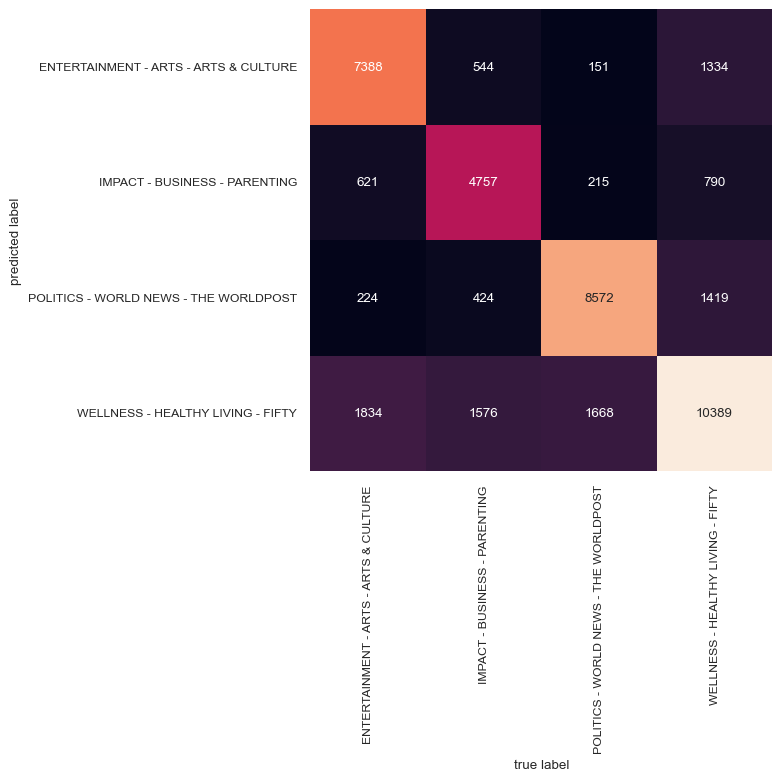

In [1281]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

np.set_printoptions(threshold=1000)

print('Overall F1 Score: {:.2%}'.format(f1_score_result))

plt.rcParams.update({'font.size': 8, 'figure.figsize': [6, 6]})
sns.set_theme(font_scale=0.8)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=dominant_categories, yticklabels=dominant_categories)
plt.xlabel('true label')
plt.ylabel('predicted label')

plt.show()

In [1282]:
headline = input('Enter a headline')
pred = model.predict([headline])
print('The headline "' + headline + '" is in the category ' + pred[0])

The headline "The Louvre Shows Off an Epic Fashion Collection" is in the category IMPACT - BUSINESS - PARENTING
